In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pizza-vs-ice-cream/README.md
/kaggle/input/pizza-vs-ice-cream/dataset/valid/pizza/00432_jpg.rf.6cd6182d2adea1c7141a9680c6e31ae0.jpg
/kaggle/input/pizza-vs-ice-cream/dataset/valid/pizza/0020_jpg.rf.51fd91f227e503a6995c70bc475f0a22.jpg
/kaggle/input/pizza-vs-ice-cream/dataset/valid/pizza/00377_jpg.rf.8362614a2cd1e84d95aa39903f15a764.jpg
/kaggle/input/pizza-vs-ice-cream/dataset/valid/pizza/00516_jpg.rf.e0b51a2313ceff675b2c0cad95dcfc5c.jpg
/kaggle/input/pizza-vs-ice-cream/dataset/valid/pizza/00528_jpg.rf.69a98a3bc42bbba85db2ec4a991f251e.jpg
/kaggle/input/pizza-vs-ice-cream/dataset/valid/pizza/00347_jpg.rf.45c78681259ddc980c03597c53b3b910.jpg
/kaggle/input/pizza-vs-ice-cream/dataset/valid/pizza/00223_jpg.rf.0ca155cbf0c356534fdcfe6a32fed7a1.jpg
/kaggle/input/pizza-vs-ice-cream/dataset/valid/pizza/00167_jpg.rf.b2cfddf30ebe4f38e1cd85cf0d68903e.jpg
/kaggle/input/pizza-vs-ice-cream/dataset/valid/pizza/00367_jpg.rf.f7943b03000d10fc8951d3b56d50d0bb.jpg
/kaggle/input/pizza-vs-ice-crea

In [2]:
import tensorflow 
import keras 
from keras.layers import Dense,Flatten
from keras.models import Model,Sequential 
from keras.preprocessing.image import ImageDataGenerator 
import matplotlib.pyplot as plt 
from keras.layers import Dense, Dropout, BatchNormalization, Input 
from keras.applications import ResNet50
from keras.applications import VGG16,VGG19 

from keras.applications.efficientnet import EfficientNetB7
from keras.callbacks import EarlyStopping,ModelCheckpoint,CSVLogger,TensorBoard 
import keras_tuner as kt 
from keras.models import load_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train = ImageDataGenerator(rotation_range=90,horizontal_flip = True, vertical_flip =True, rescale = 1./255, shear_range = 0.2,
                                   zoom_range = 0.2)
valid = ImageDataGenerator(rescale = 1./255)

test = ImageDataGenerator(rescale = 1./255)

In [4]:
training = train.flow_from_directory('/kaggle/input/pizza-vs-ice-cream/dataset/train', target_size = (417,676),class_mode = 'sparse',batch_size=32)
validation = valid.flow_from_directory('/kaggle/input/pizza-vs-ice-cream/dataset/valid',target_size = (417,676),class_mode = 'sparse',batch_size = 32)
testing = test.flow_from_directory('/kaggle/input/pizza-vs-ice-cream/dataset/test', target_size = (417,676),class_mode = 'sparse',batch_size=32)

Found 718 images belonging to 2 classes.
Found 208 images belonging to 2 classes.
Found 106 images belonging to 2 classes.


In [5]:
# CNN Architecture 
vgg=VGG16(include_top=False,
    weights='imagenet',input_shape=(417,676,3)) 

58889256/58889256 [==============================] - 2s 0us/step


In [6]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 417, 676, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 417, 676, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 417, 676, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 208, 338, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 208, 338, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 208, 338, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 104, 169, 128)     0     

In [7]:
vgg.trainable=False
for i in vgg.layers:
    if i.name.startswith("block1_"): #| i.name.startswith("block2"):
        i.trainable=False
    else:
        i.trainable=True
for i in vgg.layers:
    print(i.name, i.trainable)

input_1 True
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [8]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(417,676,3)))
    
    model.add(vgg)
    model.add(Flatten())

    # Tune the number of units in the dense layer
    model.add(Dense(units=hp.Int("dense_units", min_value=128, max_value=512),
                    activation=hp.Choice("activation",values=["sigmoid","tanh","relu"]),
                    kernel_initializer=hp.Choice("weight_init",values=["glorot_uniform","glorot_normal","he_uniform","he_normal"])))
     # Add BatchNormalization
    model.add(BatchNormalization())

    # Add Dropout
    model.add(Dropout(rate=hp.Float("dropout_rate", min_value=0.2, max_value=0.4, step=0.1)))
    
    model.add(Dense(1, activation='sigmoid'))

    optimizer_choice = hp.Choice('optimizer', values=['sgd', 'adam', 'rmsprop', 'adadelta'])

    model.compile(loss='binary_crossentropy', optimizer=optimizer_choice, metrics=['accuracy'])
    return model


In [9]:
tuner = kt.RandomSearch(build_model, objective="val_accuracy", max_trials=5,directory=r"keras_models")

tuner.search(training, epochs=15, validation_data=validation)

Trial 5 Complete [00h 12m 24s]
val_accuracy: 0.8413461446762085

Best val_accuracy So Far: 0.9230769276618958
Total elapsed time: 01h 02m 48s


In [10]:
 tuner.search_space_summary()

Search space summary
Default search space size: 5
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 1, 'sampling': 'linear'}
activation (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid', 'tanh', 'relu'], 'ordered': False}
weight_init (Choice)
{'default': 'glorot_uniform', 'conditions': [], 'values': ['glorot_uniform', 'glorot_normal', 'he_uniform', 'he_normal'], 'ordered': False}
dropout_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'sgd', 'conditions': [], 'values': ['sgd', 'adam', 'rmsprop', 'adadelta'], 'ordered': False}


In [11]:
tuner.results_summary()

Results summary
Results in keras_models/untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
dense_units: 152
activation: relu
weight_init: he_uniform
dropout_rate: 0.30000000000000004
optimizer: adam
Score: 0.9230769276618958

Trial 3 summary
Hyperparameters:
dense_units: 474
activation: sigmoid
weight_init: he_uniform
dropout_rate: 0.2
optimizer: sgd
Score: 0.9230769276618958

Trial 1 summary
Hyperparameters:
dense_units: 493
activation: tanh
weight_init: he_normal
dropout_rate: 0.4
optimizer: sgd
Score: 0.9182692170143127

Trial 0 summary
Hyperparameters:
dense_units: 494
activation: tanh
weight_init: he_normal
dropout_rate: 0.2
optimizer: rmsprop
Score: 0.8605769276618958

Trial 4 summary
Hyperparameters:
dense_units: 385
activation: tanh
weight_init: he_uniform
dropout_rate: 0.2
optimizer: rmsprop
Score: 0.8413461446762085


In [12]:
tuner.get_best_hyperparameters()[0].values

{'dense_units': 152,
 'activation': 'relu',
 'weight_init': 'he_uniform',
 'dropout_rate': 0.30000000000000004,
 'optimizer': 'adam'}

In [13]:
fmodel = tuner.get_best_models(num_models = 1)[0]
fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 13, 21, 512)       14714688  
                                                                 
 flatten (Flatten)           (None, 139776)            0         
                                                                 
 dense (Dense)               (None, 152)               21246104  
                                                                 
 batch_normalization (Batch  (None, 152)               608       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 152)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 153       
                                                        

In [14]:
es=EarlyStopping(monitor="val_loss",min_delta=0.1,patience=2,start_from_epoch=4,verbose=1) 

mc=ModelCheckpoint(r"model_checkpoint\model{epoch}.h5",monitor='val_loss',verbose=1,save_best_only=True)

In [15]:
csv=CSVLogger(r"log.csv")

In [16]:
his = fmodel.fit_generator(training,steps_per_epoch = 718 //32, epochs = 10,validation_data = validation , validation_steps = 208//32 , callbacks = [ mc, csv])

/tmp/ipykernel_47/3600318002.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  his = fmodel.fit_generator(training,steps_per_epoch = 718 //32, epochs = 10,validation_data = validation , validation_steps = 208//32 , callbacks = [ mc, csv])


Epoch 1/10
22/22 [==============================] - ETA: 0s - loss: 0.2414 - accuracy: 0.9023
Epoch 1: val_loss improved from inf to 0.19797, saving model to model_checkpoint\model1.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 49s 2s/step - loss: 0.2414 - accuracy: 0.9023 - val_loss: 0.1980 - val_accuracy: 0.9219
Epoch 2/10
22/22 [==============================] - ETA: 0s - loss: 0.2023 - accuracy: 0.9184
Epoch 2: val_loss did not improve from 0.19797
22/22 [==============================] - 46s 2s/step - loss: 0.2023 - accuracy: 0.9184 - val_loss: 0.2671 - val_accuracy: 0.8906
Epoch 3/10
22/22 [==============================] - ETA: 0s - loss: 0.1850 - accuracy: 0.9242
Epoch 3: val_loss did not improve from 0.19797
22/22 [==============================] - 47s 2s/step - loss: 0.1850 - accuracy: 0.9242 - val_loss: 0.2416 - val_accuracy: 0.9115
Epoch 4/10
22/22 [==============================] - ETA: 0s - loss: 0.2065 - accuracy: 0.9315
Epoch 4: val_loss did not improve from 0.19797
22/22 [==============================] - 47s 2s/step - loss: 0.2065 - accuracy: 0.9315 - val_loss: 0.2140 - val_accuracy: 0.9010
Epoch 5/10
22/22 [==============================] - ETA: 0s -

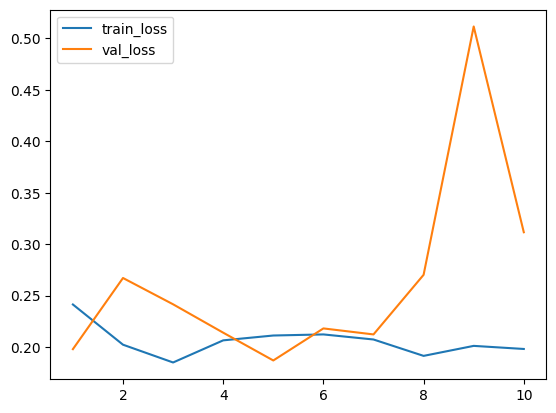

In [17]:
plt.plot(range(1,11),his.history["loss"],label="train_loss")
plt.plot(range(1,11),his.history["val_loss"],label="val_loss")
plt.legend()

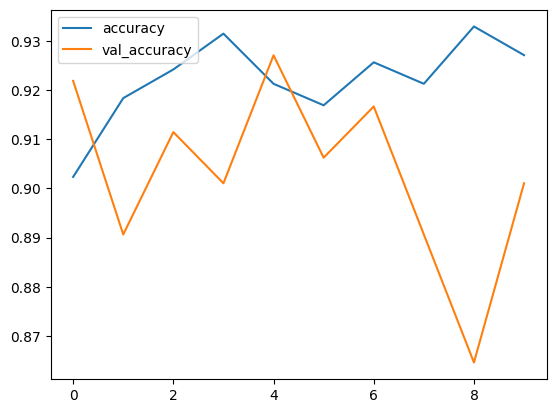

In [18]:
plt.plot(his.history['accuracy'], label='accuracy')
plt.plot(his.history['val_accuracy'], label='val_accuracy')
plt.legend(loc="upper left")
plt.show()

In [19]:
fmodel.save('best_model',save_format = 'h5')

# Read model
m1 = load_model(r'/kaggle/working/best_model') 

In [20]:
prediction = fmodel.predict(testing)

4/4 [==============================] - 5s 2s/step


In [21]:
import numpy as np 
predicted=np.where(prediction>0.5,1,0) 

accuracy_score :  0.5849056603773585


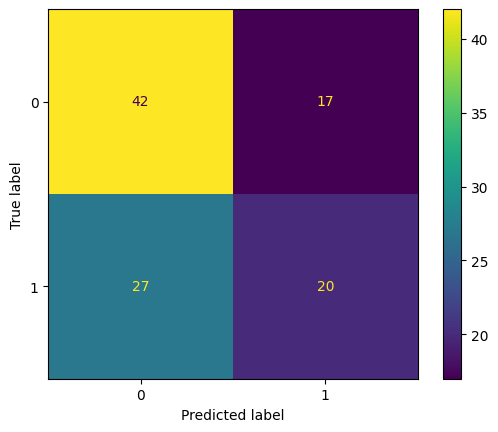

In [22]:
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,confusion_matrix
print("accuracy_score : ",accuracy_score(testing.labels,predicted)) 
cm=confusion_matrix(testing.labels,predicted)
va=ConfusionMatrixDisplay(cm)
va.plot() 
plt.show() 